In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import certifi
import requests
from matplotlib import pyplot as plt

Материалы для изучения:
- https://huggingface.co/keras-io/time-series-anomaly-detection-autoencoder
- https://huggingface.co/keras-io/timeseries-anomaly-detection
- https://github.com/elisejiuqizhang/TS-AD-Datasets
-

In [2]:
# https://keras.io/examples/timeseries/timeseries_anomaly_detection/
master_url_root = "data/archive/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [3]:
display(df_small_noise.head())

display(df_daily_jumpsup.head())

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Без аномалий

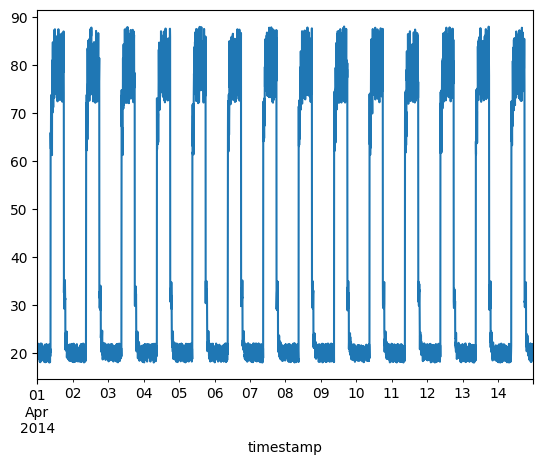

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

## С аномалиями

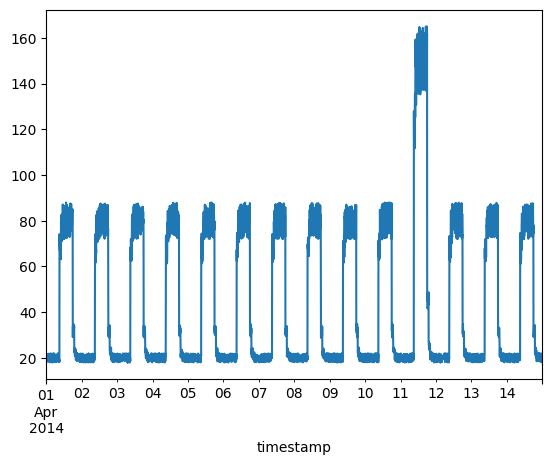

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [7]:
TIME_STEPS = 288
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


# Строю модель

export KERAS_BACKEND="torch"

Мы построим модель автоэнкодера сверточной реконструкции. Модель будет принимать входные данные формы (batch_size, sequence_length, num_features)и возвращать выходные данные той же формы. В данном случае sequence_lengthэто 288 и num_featuresравно 1.

In [8]:
# https://stackoverflow.com/questions/78173150/attributeerror-module-keras-src-backend-has-no-attribute-variable-with-drop

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

# Тренирую модель
На входе используется как x_train, так и целевые значения, тк это модель реконструкции.


In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.7954 - val_loss: 0.0614
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0803 - val_loss: 0.0408
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0566 - val_loss: 0.0348
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0492 - val_loss: 0.0293
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0437 - val_loss: 0.0267
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0388 - val_loss: 0.0242
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0346 - val_loss: 0.0225
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0315 - val_loss: 0.0209
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0290 - val_loss: 0.0205
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0254 - val_loss: 0.0183
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

Давайте построим график потерь при обучении и проверке, чтобы увидеть, как прошло обучение.

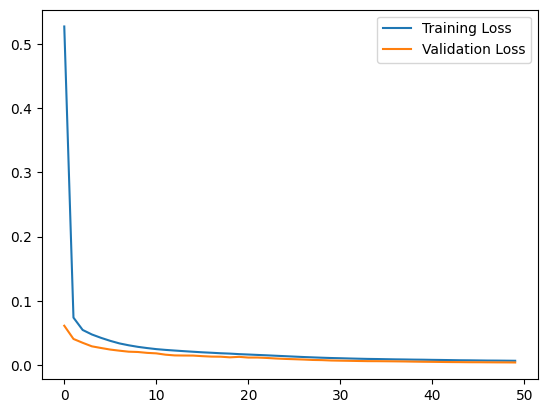

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Обнаружение аномалий
Мы обнаружим аномалии, определив, насколько хорошо наша модель может восстановить входные данные.
Найдите потерю MAE на обучающих выборках.
Найдите максимальное значение потерь MAE. Это худшее, что наша модель показала при попытке восстановить выборку. Мы сделаем это thresholdдля обнаружения аномалий.
Если потери при реконструкции выборки превышают это threshold значение, мы можем сделать вывод, что модель видит закономерность, с которой она не знакома. Мы обозначим этот образец как файл anomaly.

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


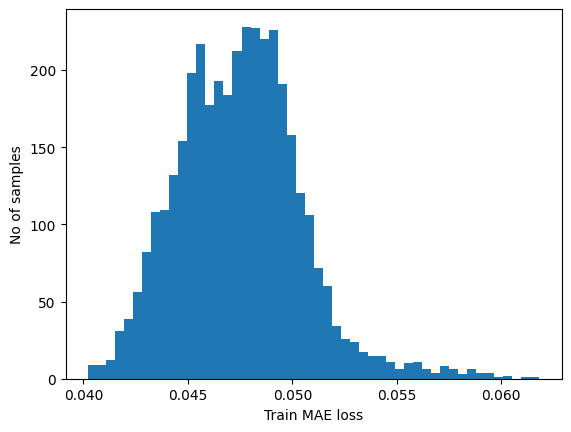

Reconstruction error threshold:  0.061811969678505725


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Сравнить реконструкцию
Просто ради интереса давайте посмотрим, как наша модель реконструировала первый образец. Это 288 временных шагов с первого дня нашего набора тренировочных данных.

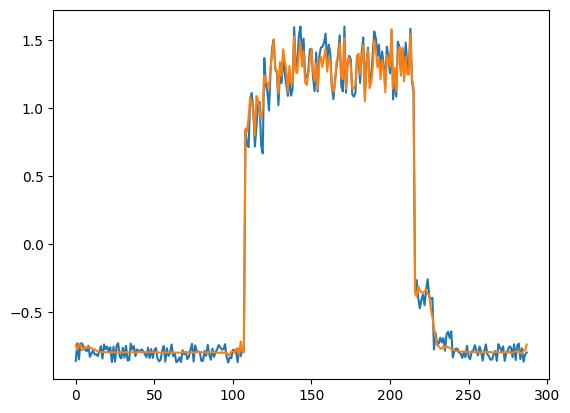

In [13]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

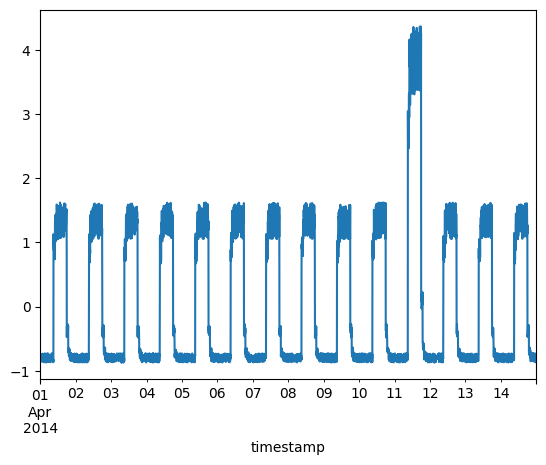

Test input shape:  (3745, 288, 1)
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


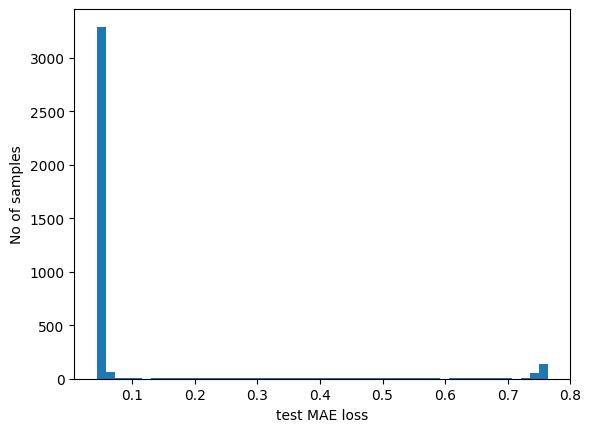

Number of anomaly samples:  406
Indices of anomaly samples:  (array([ 216,  792,  793,  794,  973, 1369, 2520, 2521, 2522, 2698, 2701,
       2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2

In [18]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies));

График аномалий
Теперь мы знаем образцы данных, которые являются аномалиями. При этом мы найдем соответствующие timestampsисходным тестовым данным. Для этого мы будем использовать следующий метод:

Допустим, time_steps = 3, и у нас есть 10 обучающих значений. Наш x_trainбудет выглядеть так:

0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
Все значения данных time_steps-1, кроме начального и конечного, будут отображаться в time_stepsколичестве выборок. Итак, если мы знаем, что выборки [(3, 4, 5), (4, 5, 6), (5, 6, 7)] являются аномалиями, мы можем сказать, что точка данных 5 является аномалией.

In [19]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Давайте наложим аномалии на исходный график тестовых данных.

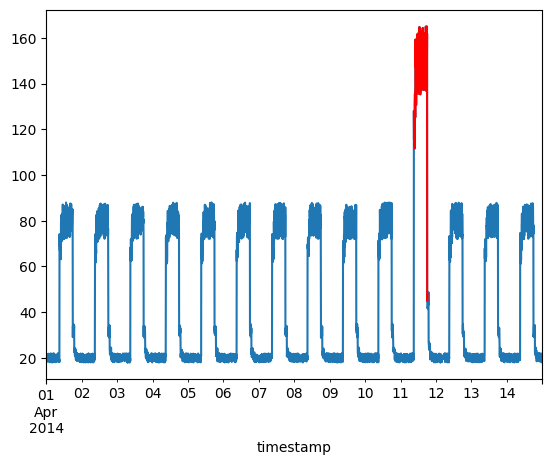

In [20]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()